##### This notebook provides a model-predictive controller to simulate a closed-loop plasma system with redundant states. 

System and data taken from [Chan et. al 2023](https://ieeexplore.ieee.org/document/10156650/)

Mesbah Lab at University of California, Berkeley

For all questions regarding this code, contact melanie.huynh (at) berkeley.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from copy import *
import scipy.io
from numpy.random import default_rng

Load in system specific information

In [2]:
model = scipy.io.loadmat('data/subspace_id.mat') # 5 state model 

Np = 5 # prediction horizon
Ns = 60 # simulation horizon
ts = 0.5 # sampling time
Tref = 43.0 # reference temperature
Tmax = 45.0 # max temp. for patient comfort
Kcem = 0.5 
cem0 = 1.5 # target CEM

# state, input, state-transition, and observation matrices
A, B, C = model['A'], model['B'], model['C']
nx, nu, ny, nyc = A.shape[0], B.shape[1], C.shape[0], 1

# centering input and output about steady-state (ss)
yss = np.ravel(model['yss']) 
uss = np.ravel(model['uss']) 

# constraint bounds, centered about ss
u_min = np.array([1.5, 3.5]) - uss
u_max = np.array([3.5, 7.5]) - uss
y_min = np.array([25, 0]) - yss
y_max = np.array([Tmax, 80]) - yss

# assume values begin at equilibrium
u_init = np.zeros(nu)
y_init = np.zeros(ny)
x_init = np.zeros(nx)  

# noise normal distribution paramaters
mu = 0.
sigma = 10E-3

In [ ]:
# Kalman filter user-tunable values #

# covariance process noise, covariance observation noise, constant
Qw = np.random.normal(loc=0.0, scale=5.0, size=(nx, nx))
Rv = np.random.normal(loc=0.0, scale=10E-3, size=(nu, nu))

# initial covariance matrix (taken from open-loop), initial estimated state
P_init = np.array([[ -37.12714472,  -35.92843492,   27.00803341,   26.25232629,
          25.67289733],
       [ -34.85921727,  -31.94013518,   27.49576814,   26.79955262,
          26.23298172],
       [  -5.6972025 ,   -0.43869857, -146.5089438 , -147.33630786,
        -145.43272797],
       [  -2.74710349,    2.27625055, -147.59988828, -146.37254568,
        -145.4503817 ],
       [  -3.44684231,    1.55484568, -145.19779664, -144.98791566,
        -142.10142188]])
xhat_init = np.zeros(nx)

Set up controller, working on deviation values.

In [17]:
opti = Opti() 

# define symbols
x = SX.sym('x', nx)
u = SX.sym('u', nu)
y = SX.sym('y', ny)

# Linearized evolution equations
f = Function('f', [x, u], [A @ x + B @ u])
h = Function('h', [x], [C @ x])

# nonlinear CEM equations, based on observable surface temperature
lstg = (Kcem ** (Tref - (y[0] + yss[0])) ) * ts / 60
lstage = Function('lstage', [y], [lstg])
CEM = ( Kcem ** (Tref - (y[0] + yss[0])) ) * ts / 60
CEMadd = Function('CEMadd', [y], [CEM])

# containers
X = [0 for _ in range(Np + 1)]
U = [0 for _ in range(Np)]
Y = [0 for _ in range(Np + 1)]
J = 0

# target/reference output, fixed during optimization
CEMref = opti.parameter(nyc)
opti.set_value(CEMref, cem0)

# initial CEM 
CEM0 = opti.parameter(nyc) 
opti.set_value(CEM0, 0.)

X[0] = opti.parameter(nx) # initial state as parameter
opti.set_value(X[0], np.zeros(nx)) # set value of initial state parameter

Y[0] = opti.variable(ny) # initial output variable
opti.subject_to(Y[0] == h(X[0])) # define output constraints based on initial state
opti.set_initial(Y[0], y_init) # define initial output 

# systematically define variables of the OCP over the prediction horizon
for k in range(Np): 
    # control input u as variable, initialized, and constrained
    U[k] = opti.variable(nu)
    opti.subject_to(opti.bounded(u_min, U[k], u_max))
    opti.set_initial(U[k], u_init)

    # increment stage cost, based on output 
    Jstage = lstage(Y[k])
    J += Jstage

    # state x as variable and initialized 
    X[k + 1] = opti.variable(nx) 
    opti.set_initial(X[k + 1], x_init)

    # output y as variable, constrained, and initialized
    Y[k + 1] = opti.variable(ny) 
    opti.subject_to(opti.bounded(y_min, Y[k + 1], y_max)) 
    opti.set_initial(Y[k + 1], y_init)

    # dynamics constraint
    opti.subject_to(X[k + 1] == f(X[k], U[k]))
    
    # output constraint
    opti.subject_to(Y[k + 1] == h(X[k + 1]))

# calculate the terminal cost, note no splits or iterations
J += lstage(Y[-1])
J = (CEMref - (J + CEM0)) ** 2

# minimize cost
opti.minimize(J)

p_opts = {'verbose': False, 'expand': True, 'print_time': 1} # options taken from K.C. --> Ipopt options to print to console
s_opts = {'max_iter': 1000, 'print_level': 1, 'tol': 1e-6}

opti.solver('ipopt', p_opts, s_opts)

soln = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   8.00us (  1.14us)   5.37us (767.14ns)         7
       nlp_g  |  13.00us (  1.86us)   9.51us (  1.36us)         7
  nlp_grad_f  |   9.00us (  1.12us)   7.67us (958.50ns)         8
  nlp_hess_l  |   8.00us (  1.33us)   6.17us (  1.03us)         6
   nlp_jac_g  |  14.00us (  1.75us)  13.05us (  1.63us)         8
       total  |   2.60ms (  2.60ms)   2.59ms (  2.59ms)         1


Run the plant/simulation over simulation horizon

In [18]:
# generate normal RNG with same seed for consistent simulations
rng = default_rng()
V_sim = rng.normal(0, 10E-3, size=(ny, Ns + 1))

# containers
# * Plant x, u, y 
X_sim = np.zeros((nx, Ns + 1)) # state trajectories
U_sim = np.zeros((nu, Ns)) # input trajectories
Y_sim = np.zeros((ny, Ns + 1)) # output trajectories
# * Plant accumulating CEM value
CEMsim = np.zeros(Ns + 1) # CEM trajectory
# * State estimator and KF covariance matrix 
X_est = np.zeros((nx, Ns + 1))
P_est = np.zeros((Ns + 1, nx, nx))

# set initial state, output, and Kalman Filter
X_sim[:, 0] = np.ravel(x_init)
X_est[:, 0] = X_sim[:, 0]
# * KF covariance matrix
P_est[0] = P_init
# * apply 0-mean noise to observable 
Y_sim[:, 0] = np.ravel(h(X_sim[:, 0]).full()) + V_sim[:, 0]

In [19]:
# run closed-loop plant over simulation horizon
for k in range(Ns):          
    # compute control input
    # * set parameters
    opti.set_value(X[0], X_est[:, k])
    opti.set_value(CEM0, CEMsim[k])
    # * solve and extract control inputs from controller
    sol = opti.solve() 
    U_soln = np.asarray([sol.value(u) for u in U]).reshape(nu, -1)
    U_sim[:, k] = U_soln[:, 0] 
    
    # send optimal input to plant
    X_sim[:, k + 1] = np.ravel(f(X_sim[:, k], U_sim[:, k]).full()) # apply input to state system/plant
    # apply noise to output
    Y_sim[:, k + 1] = np.ravel(h(X_sim[:, k + 1]).full()) + V_sim[:, k + 1]
    
    # collect CEM value
    CEMsim[k + 1] = CEMsim[k] + np.ravel(CEMadd(Y_sim[:, k + 1]).full())
    
    # get estimates for state using observer
    # --- KALMAN FILTER ---
    # * Take the control input from controller and the output observable,
    # *     input into Kalman filter 
    # * A priori estimate, prediction
    xphat = A @ X_est[:, k] + B @ U_sim[:, k]
    Pphat = A @ P_est[k] @ np.transpose(A) + Qw

    # * Measurement update, correction
    # * * Compute Kalman gain
    yr = Y_sim[:, k] - (C @ xphat) # Measurement pre-fit residual
    Sk = C @ Pphat @ np.transpose(C) + Rv # Innovation/pre-fit residual covariance
    Kk = Pphat @ np.transpose(C) @ inv(Sk) # Optimal Kalman gain
    # * * Update estimate with measurement and uncertainty
    xhat = xphat + Kk @ yr
    Phat = np.identity(A.shape[0]) - Kk @ C @ Pphat
    
    # * Store Kalman filter results
    X_est[:, k + 1] = np.ravel(xhat)
    P_est[k + 1] = Phat
    # ----------------------    

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  50.00us (  3.57us)  15.76us (  1.13us)        14
       nlp_g  |  31.00us (  2.21us)  25.42us (  1.82us)        14
    nlp_grad  |   3.00us (  3.00us)   3.55us (  3.55us)         1
  nlp_grad_f  |  25.00us (  1.56us)  20.63us (  1.29us)        16
  nlp_hess_l  |  20.00us (  1.67us)  16.39us (  1.37us)        12
   nlp_jac_g  |  36.00us (  2.25us)  35.47us (  2.22us)        16
       total  |   4.49ms (  4.49ms)   4.45ms (  4.45ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  57.00us (  2.48us)  21.47us (933.61ns)        23
       nlp_g  |  48.00us (  2.09us)  38.55us (  1.68us)        23
    nlp_grad  |   8.00us (  4.00us)   7.88us (  3.94us)         2
  nlp_grad_f  |  50.00us (  1.92us)  43.89us (  1.69us)        26
  nlp_hess_l  |  31.00us (  1.55us)  24.88us (  1.24us)        20
   nlp_jac_g  |  53.00us (  2.04us)  52.00us (  2.00us)        26
       tot

       total  |   3.79ms (  3.79ms)   3.79ms (  3.79ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 377.00us (845.29ns) 304.24us (682.15ns)       446
       nlp_g  | 813.00us (  1.82us) 693.63us (  1.56us)       446
    nlp_grad  | 149.00us (  2.98us) 140.35us (  2.81us)        50
  nlp_grad_f  | 524.00us (  1.05us) 449.78us (904.98ns)       497
  nlp_hess_l  | 476.00us (  1.21us) 409.77us (  1.04us)       395
   nlp_jac_g  | 834.00us (  1.68us) 829.94us (  1.67us)       497
       total  |   4.13ms (  4.13ms)   4.13ms (  4.13ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 385.00us (840.61ns) 312.10us (681.45ns)       458
       nlp_g  | 832.00us (  1.82us) 711.85us (  1.55us)       458
    nlp_grad  | 152.00us (  2.98us) 142.86us (  2.80us)        51
  nlp_grad_f  | 536.00us (  1.05us) 460.53us (903.00ns)       510
  nlp_hess_l  | 487.00us (  1.20us) 420.70us (  1.04us)       406
   nlp_jac

Confirm KF estimates

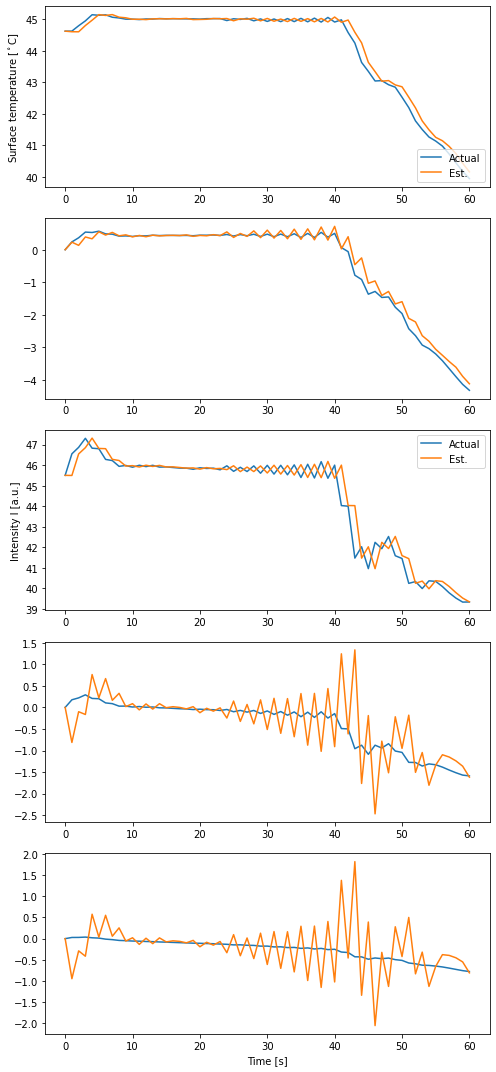

In [25]:
x_axis = np.arange(Ns + 1)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(7, 15))   

# State 1
ax1.plot(np.arange(Ns + 1), np.ravel(X_sim[0]) + yss[0], label='Actual')
ax1.plot(np.arange(Ns + 1), np.ravel(X_est[0]) + yss[0], label='Est.')
ax1.set_ylabel('Surface temperature [$^\circ$C]')
ax1.legend(loc='lower right')

# State 2
ax3.plot(np.arange(Ns + 1), np.ravel(X_sim[2]) + yss[1], label='Actual')
ax3.plot(np.arange(Ns + 1), np.ravel(X_est[2]) + yss[1], label='Est.')
ax3.set_ylabel('Intensity I [a.u.]')
ax3.legend()

ax2.plot(x_axis, np.ravel(X_sim[1]), label='actual')
ax2.plot(x_axis, np.ravel(X_est[1]), label='est.')
ax2.set_ylabel('')

ax4.plot(x_axis, np.ravel(X_sim[3]), label='actual')
ax4.plot(x_axis, np.ravel(X_est[3]), label='est.')
ax4.set_ylabel('')

ax5.plot(x_axis, np.ravel(X_sim[4]), label='actual')
ax5.plot(x_axis, np.ravel(X_est[4]), label='est.')
ax5.set_ylabel('')

ax5.set_xlabel('Time [s]')
plt.tight_layout()

Plot observables and control inputs

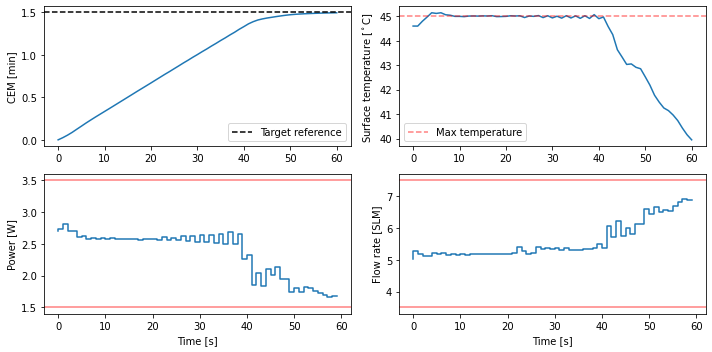

In [24]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 5)) 
# # I
# ax2.plot(np.arange(Y_sim[1].shape[0]), np.ravel(Y_sim[1]) + yss[1])
# ax2.set_ylabel('I [a.u.]')
# CEM
ax1.plot(np.arange(Ns + 1), CEMsim)
ax1.axhline([1.5], linestyle='--', color='black', label='Target reference')
ax1.set_ylabel('CEM [min]')
ax1.legend()

# Ts
ax2.plot(np.arange(Ns + 1), np.ravel(Y_sim[0]) + yss[0])
ax2.axhline([45.], color='red', linestyle='--', label='Max temperature', alpha=0.5)
ax2.set_ylabel('Surface temperature [$^\circ$C]')
ax2.legend()

# P
ax3.step(np.arange(U_sim[0].shape[0]), np.ravel(U_sim[0]) + uss[0])
ax3.axhline([u_max[0] + uss[0]], color='r', alpha=0.5)
ax3.axhline([u_min[0] + uss[0]], color='r', alpha=0.5)
ax3.set_ylabel('Power [W]')
ax3.set_xlabel('Time [s]')
# q
ax4.step(np.arange(U_sim[1].shape[0]), np.ravel(U_sim[1]) + uss[1])
ax4.axhline([u_max[1] + uss[1]], color='r', alpha=0.5)
ax4.axhline([u_min[1] + uss[1]], color='r', alpha=0.5)
ax4.set_ylabel('Flow rate [SLM]')
ax4.set_xlabel('Time [s]')

plt.tight_layout()